# Package install

In [1]:
!pip install mtcnn
!pip install lz4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 MB/s eta 0:00:00


In [2]:
!pip show tensorflow


Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


# Import library

In [22]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Flatten


# Verification GPU Active

In [7]:
import torch
torch.cuda.is_available()


True

In [8]:
import tensorflow as tf

# Liste des dispositifs GPU détectés
gpus = tf.config.list_physical_devices('GPU')
print("GPU disponibles :", gpus)

# Affiche le nom du GPU utilisé (si disponible)
print("GPU en cours d'utilisation :", tf.test.gpu_device_name())


GPU disponibles : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU en cours d'utilisation : /device:GPU:0


In [6]:
!nvidia-smi


Thu Mar 13 14:07:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             51W /  400W |     423MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Preparation des données

In [11]:
import zipfile
import os

# Chemin vers le fichier zip
zip_path = 'affectnet_processed_traitement_v1.zip'

# Dossier de destination
extract_to = 'dataset_2'

# Création du dossier de destination s'il n'existe pas
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extraction du contenu du fichier zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extraction terminée dans le dossier {extract_to}.")


Extraction terminée dans le dossier dataset_2.


In [12]:
# -----------------------------------------------------------------------------
# 2. Dictionnaire des émotions basé sur AffectNet
# -----------------------------------------------------------------------------
emotion_dict = {
    0: "neutral",
    1: "happy",
    2: "sad",
    3: "surprise",
    4: "fear",
    5: "disgust",
    6: "angry"
}


In [13]:
# -----------------------------------------------------------------------------
# 3. Définition des chemins vers le nouveau dataset
# -----------------------------------------------------------------------------
# La structure du dataset_2 est la suivante :
# dataset_2/
# ├── train/
# │   ├── 0
# │   ├── 1
# │   ├── 2
# │   ├── 3
# │   ├── 4
# │   ├── 5
# │   └── 6
# └── val/
#     ├── 0
#     ├── 1
#     ├── 2
#     ├── 3
#     ├── 4
#     ├── 5
#     └── 6
new_train_dir = '/content/dataset_2/train'
new_val_dir   = '/content/dataset_2/val'

In [14]:
# -----------------------------------------------------------------------------
# 4. Création de DataFrames pour visualiser une image par classe
# -----------------------------------------------------------------------------
def create_df_from_directory(directory):
    data = []
    for folder in sorted(os.listdir(directory)):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            img_files = os.listdir(folder_path)
            if len(img_files) > 0:
                first_img = os.path.join(folder_path, img_files[0])
                data.append({"img_path": first_img, "label": int(folder)})
    return pd.DataFrame(data)

df_train = create_df_from_directory(new_train_dir)
df_val   = create_df_from_directory(new_val_dir)


Exemples d'images dans l'ensemble d'entraînement :


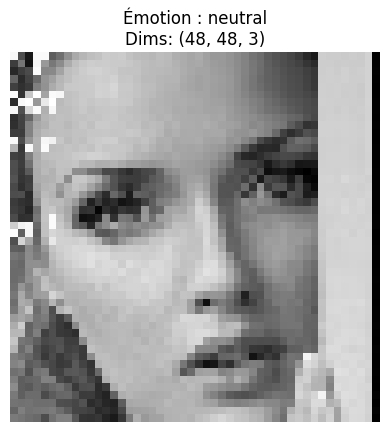

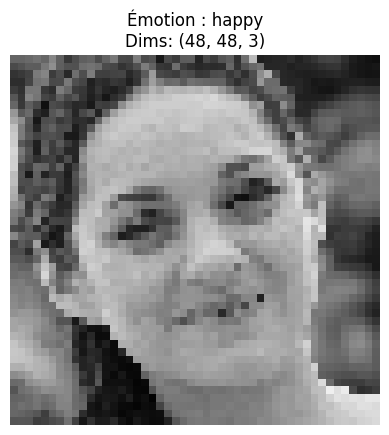

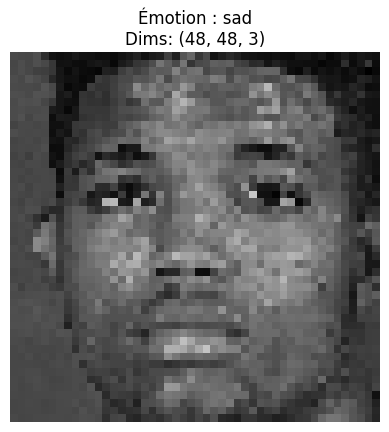

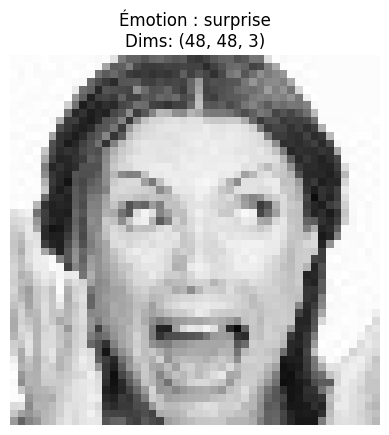

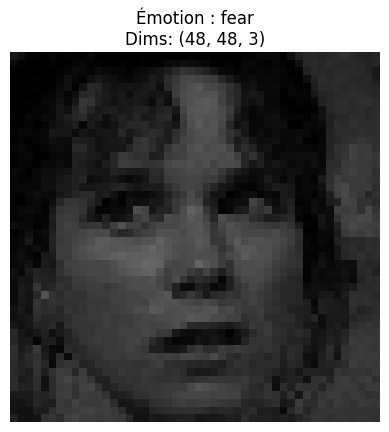

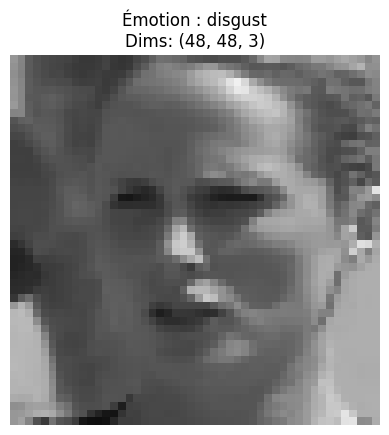

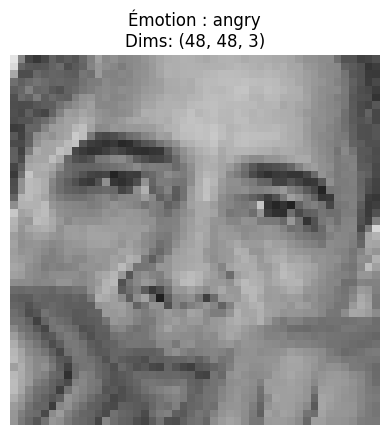

Exemples d'images dans l'ensemble de validation :


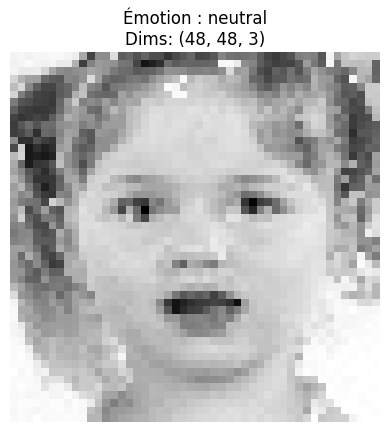

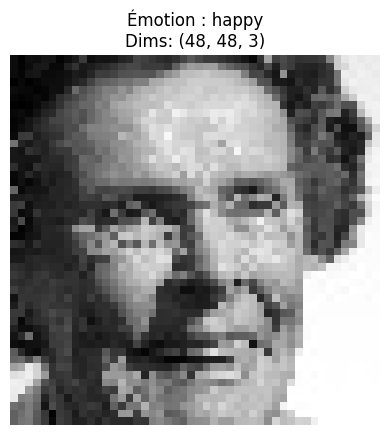

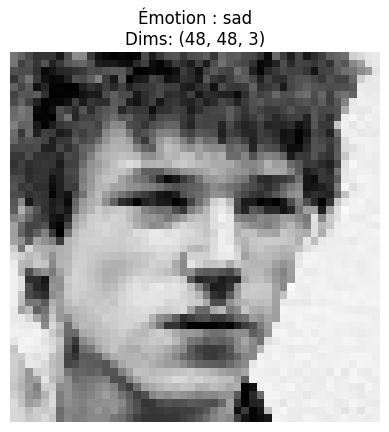

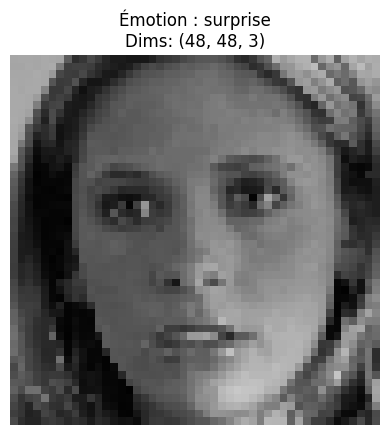

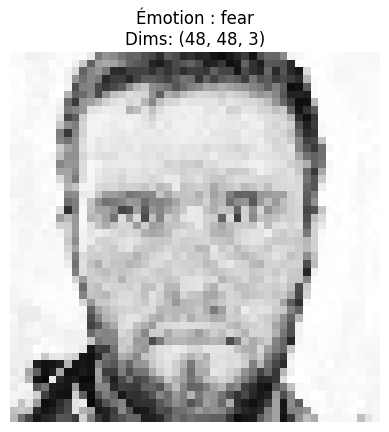

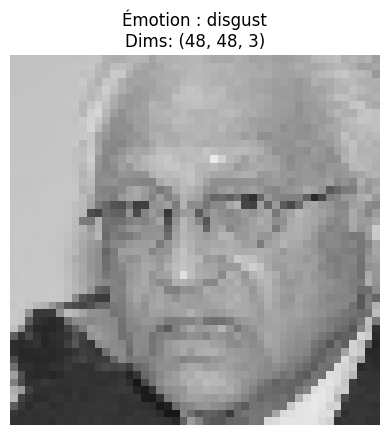

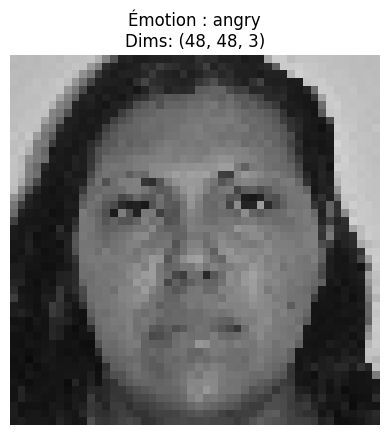

In [15]:
# -----------------------------------------------------------------------------
# 5. Fonction d'affichage d'une image avec son label et ses dimensions
# -----------------------------------------------------------------------------
def afficher_image(df, index):
    chemin_image = df.loc[index, 'img_path']
    label = df.loc[index, 'label']
    image = cv2.imread(chemin_image)
    if image is None:
        print(f"Image introuvable : {chemin_image}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dims = image.shape  # (hauteur, largeur, canaux)
    plt.imshow(image_rgb)
    plt.title(f"Émotion : {emotion_dict.get(label, 'Inconnu')}\nDims: {dims}")
    plt.axis('off')
    plt.show()

# Affichage d'exemples d'images pour chaque classe dans l'ensemble d'entraînement
print("Exemples d'images dans l'ensemble d'entraînement :")
for lab in df_train['label'].unique():
    idx = df_train[df_train['label'] == lab].index[0]
    afficher_image(df_train, idx)

# Affichage d'exemples d'images pour chaque classe dans l'ensemble de validation
print("Exemples d'images dans l'ensemble de validation :")
for lab in df_val['label'].unique():
    idx = df_val[df_val['label'] == lab].index[0]
    afficher_image(df_val, idx)

## Training approchement 1 -> Fine tunning

In [16]:
# -----------------------------------------------------------------------------
# Pour l'entraînement : augmentation légère + normalisation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255
)

# Pour la validation : seule la normalisation
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=new_train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    directory=new_val_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

Found 227219 images belonging to 7 classes.
Found 3491 images belonging to 7 classes.


In [21]:
# -----------------------------------------------------------------------------
# 8. Construction du nouveau modèle en ajoutant de nouvelles couches
# -----------------------------------------------------------------------------
# Chargement de l'ancien modèle
old_model = load_model('best_model.h5')
old_model.summary()

# Créer un tenseur d'entrée explicite (correspondant à la forme de vos images)
new_input = Input(shape=(48, 48, 1))

# Passer ce nouvel input à travers toutes les couches de l'ancien modèle sauf la dernière
x = new_input
for layer in old_model.layers[:-1]:
    x = layer(x)
base_output = x

# Geler les couches de l'ancien modèle pour conserver leurs poids
for layer in old_model.layers:
    layer.trainable = False

# Ajout de nouvelles couches supplémentaires avec des noms uniques pour éviter les conflits
x = Dense(256, activation='relu', name='new_dense')(base_output)
x = BatchNormalization(name='new_batch_norm')(x)
x = Dropout(0.5, name='new_dropout')(x)
new_output = Dense(7, activation='softmax', name='new_output')(x)

# Création du nouveau modèle en spécifiant le nouvel input et la nouvelle sortie
new_model = Model(new_input, new_output)
new_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,478,729 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 2 (12.00 B)

Model: "functional_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,609,287 (17.58 MB)

 Trainable params: 133,639 (522.03 KB)

 Non-trainable params: 4,475,648 (17.07 MB)

In [23]:

# -----------------------------------------------------------------------------
# 9. Compilation du nouveau modèle
# -----------------------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# -----------------------------------------------------------------------------
# 10. Définition des callbacks pour l'entraînement
# -----------------------------------------------------------------------------
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_updated.h5',  # Chemin de sauvegarde du meilleur modèle
        monitor='val_accuracy',            # Surveillance de l'exactitude sur le set de validation
        save_best_only=True,               # Sauvegarder uniquement le modèle avec la meilleure performance
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',                # Arrêt anticipé en cas de stagnation de la perte sur le set de validation
        patience=10,                       # Nombre d'époques d'attente avant arrêt
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',                # Réduction du learning rate si la perte de validation ne s'améliore pas
        factor=0.5,
        patience=5,
        verbose=1
    )
]

# -----------------------------------------------------------------------------
# 11. Entraînement du nouveau modèle sur le nouveau dataset
# -----------------------------------------------------------------------------
history = new_model.fit(
    train_generator,
    epochs=50,  # Vous pouvez ajuster le nombre d'époques
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3550/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4991 - loss: 1.6222
Epoch 1: val_accuracy improved from -inf to 0.33543, saving model to best_model_updated.h5


3551/3551 ━━━━━━━━━━━━━━━━━━━━ 159s 43ms/step - accuracy: 0.4991 - loss: 1.6221 - val_accuracy: 0.3354 - val_loss: 1.8602 - learning_rate: 1.0000e-04
Epoch 2/50
3550/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5843 - loss: 1.1839
Epoch 2: val_accuracy improved from 0.33543 to 0.33887, saving model to best_model_updated.h5


3551/3551 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.5843 - loss: 1.1839 - val_accuracy: 0.3389 - val_loss: 1.8775 - learning_rate: 1.0000e-04
Epoch 3/50
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5978 - loss: 1.1345
Epoch 3: val_accuracy improved from 0.33887 to 0.34030, saving model to best_model_updated.h5


3551/3551 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.5978 - loss: 1.1345 - val_accuracy: 0.3403 - val_loss: 1.8889 - learning_rate: 1.0000e-04
Epoch 4/50
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6040 - loss: 1.1132
Epoch 4: val_accuracy did not improve from 0.34030
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.6040 - loss: 1.1132 - val_accuracy: 0.3386 - val_loss: 1.8864 - learning_rate: 1.0000e-04
Epoch 5/50
3550/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6050 - loss: 1.1047
Epoch 5: val_accuracy improved from 0.34030 to 0.34145, saving model to best_model_updated.h5


3551/3551 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.6050 - loss: 1.1047 - val_accuracy: 0.3414 - val_loss: 1.8783 - learning_rate: 1.0000e-04
Epoch 6/50
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6073 - loss: 1.0995
Epoch 6: val_accuracy improved from 0.34145 to 0.34746, saving model to best_model_updated.h5



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.6073 - loss: 1.0995 - val_accuracy: 0.3475 - val_loss: 1.8643 - learning_rate: 1.0000e-04
Epoch 7/50
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6061 - loss: 1.0990
Epoch 7: val_accuracy did not improve from 0.34746
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.6061 - loss: 1.0990 - val_accuracy: 0.3466 - val_loss: 1.8700 - learning_rate: 5.0000e-05
Epoch 8/50
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6087 - loss: 1.0953
Epoch 8: val_accuracy did not improve from 0.34746
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.6087 - loss: 1.0953 - val_accuracy: 0.3455 - val_loss: 1.8741 - learning_rate: 5.0000e-05
Epoch 9/50
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6080 - loss: 1.0958
Epoch 9: val_accuracy did not improve from 0.34746
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accur

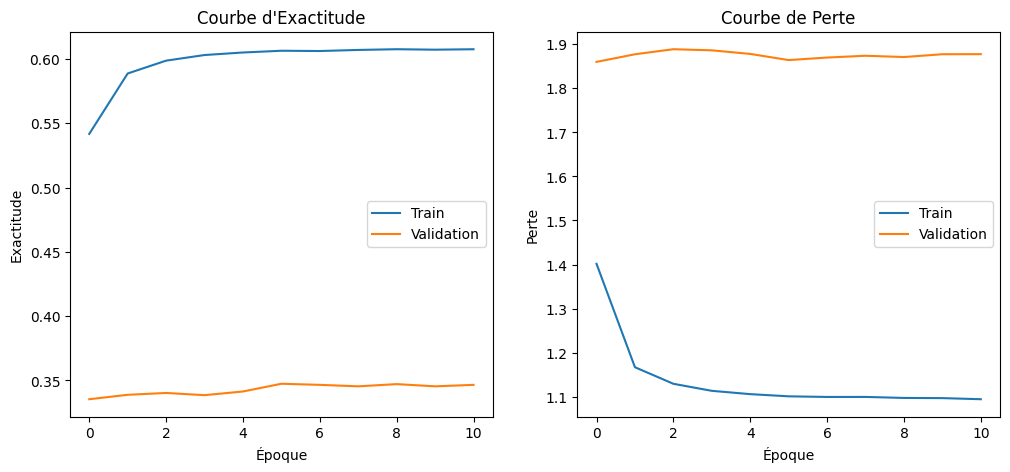

In [25]:
# -----------------------------------------------------------------------------
# 12. Visualisation des courbes d'entraînement (accuracy et loss)
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Courbe d'exactitude
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Exactitude')
plt.legend()
plt.title("Courbe d'Exactitude")

# Courbe de la perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Courbe de Perte")
plt.show()

In [ ]:

# -----------------------------------------------------------------------------
# 13. Sauvegarde finale du nouveau modèle entraîné
# -----------------------------------------------------------------------------
new_model.save('final_model_updated.h5')

## Training approchement 2
2 niveau du fine tunning

In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Vérification de l'utilisation du GPU
print("GPU en cours d'utilisation :", tf.test.gpu_device_name())

# -----------------------------------------------------------------------------
# Phase 0 : Chargement de l'ancien modèle
# -----------------------------------------------------------------------------
old_model = load_model('best_model.h5')
old_model.summary()

# -----------------------------------------------------------------------------
# Phase 1 : Construction du nouveau modèle avec la base gelée
# -----------------------------------------------------------------------------
# On crée un nouvel input explicite
new_input = Input(shape=(48, 48, 1))

# Passage de new_input à travers toutes les couches de l'ancien modèle sauf la dernière
x = new_input
for layer in old_model.layers[:-1]:
    layer.trainable = False  # Gel de toute la base
    x = layer(x)
base_output = x

# Ajout de nouvelles couches sur la base extraite
x = Dense(256, activation='relu', name='new_dense')(base_output)
x = BatchNormalization(name='new_batch_norm')(x)
x = Dropout(0.5, name='new_dropout')(x)
# IMPORTANT : On ajuste le nombre de neurones de sortie à 8 pour le nouveau dataset
new_output = Dense(8, activation='softmax', name='new_output')(x)

# Création du nouveau modèle
new_model = Model(new_input, new_output)
new_model.summary()

# -----------------------------------------------------------------------------
# Compilation du modèle pour la Phase 1
# -----------------------------------------------------------------------------
optimizer_phase1 = tf.keras.optimizers.Adam(learning_rate=1e-4)
new_model.compile(optimizer=optimizer_phase1, loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------------------------------------------------------
# Préparation des générateurs d'images (avec augmentation)
# -----------------------------------------------------------------------------
train_dir = '/content/dataset_2/train'
val_dir = '/content/dataset_2/val'

# Générateur pour l'entraînement avec augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255
)

# Générateur pour la validation (seulement normalisation)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

# -----------------------------------------------------------------------------
# Callbacks pour la Phase 1
# -----------------------------------------------------------------------------
callbacks_phase1 = [
    ModelCheckpoint(filepath='best_model_phase1.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    TensorBoard(log_dir='./logs_phase1', histogram_freq=1),
    CSVLogger('training_phase1.csv', append=True)
]

# -----------------------------------------------------------------------------
# Entraînement - Phase 1 : Entraîner les nouvelles couches avec la base gelée
# -----------------------------------------------------------------------------
print("Phase 1 : Entraînement avec la base gelée")
history_phase1 = new_model.fit(
    train_generator,
    epochs=10,  # Vous pouvez ajuster le nombre d'époques
    validation_data=val_generator,
    callbacks=callbacks_phase1
)

# -----------------------------------------------------------------------------
# Phase 2 : Fine-tuning en débloquant partiellement la base
# -----------------------------------------------------------------------------
# Ici, nous choisissons de débloquer les 4 dernières couches de l'ancien modèle pour permettre un ajustement plus fin.
for layer in old_model.layers[-4:]:
    layer.trainable = True

# Recompilez le modèle avec un taux d'apprentissage plus faible pour le fine-tuning
optimizer_phase2 = tf.keras.optimizers.Adam(learning_rate=1e-5)
new_model.compile(optimizer=optimizer_phase2, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks pour la Phase 2
callbacks_phase2 = [
    ModelCheckpoint(filepath='best_model_phase2.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    TensorBoard(log_dir='./logs_phase2', histogram_freq=1),
    CSVLogger('training_phase2.csv', append=True)
]

# -----------------------------------------------------------------------------
# Entraînement - Phase 2 : Fine-tuning avec une partie de la base débloquée
# -----------------------------------------------------------------------------
print("Phase 2 : Fine-tuning avec les dernières couches débloquées")
history_phase2 = new_model.fit(
    train_generator,
    epochs=20,  # Vous pouvez augmenter ce nombre pour un fine-tuning plus poussé
    validation_data=val_generator,
    callbacks=callbacks_phase2
)

# -----------------------------------------------------------------------------
# Sauvegarde finale du modèle
# -----------------------------------------------------------------------------
new_model.save('final_model_updated.keras')


GPU en cours d'utilisation : /device:GPU:0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,478,729 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 2 (12.00 B)

Model: "functional_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,609,544 (17.58 MB)

 Trainable params: 133,896 (523.03 KB)

 Non-trainable params: 4,475,648 (17.07 MB)

Found 227219 images belonging to 8 classes.
Found 3491 images belonging to 8 classes.
Phase 1 : Entraînement avec la base gelée
Epoch 1/10
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5036 - loss: 1.6419
Epoch 1: val_accuracy improved from -inf to 0.33257, saving model to best_model_phase1.keras
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 157s 42ms/step - accuracy: 0.5036 - loss: 1.6419 - val_accuracy: 0.3326 - val_loss: 1.9035 - learning_rate: 1.0000e-04
Epoch 2/10
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5831 - loss: 1.1987
Epoch 2: val_accuracy improved from 0.33257 to 0.33572, saving model to best_model_phase1.keras
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 146s 41ms/step - accuracy: 0.5831 - loss: 1.1987 - val_accuracy: 0.3357 - val_loss: 1.9062 - learning_rate: 1.0000e-04
Epoch 3/10
3550/3551 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5948 - loss: 1.1406
Epoch 3: val_accuracy improved from 0.33572 to 0.33887, saving model to best_model_phase1.keras
3551/3551 ━━━━━━━━━━

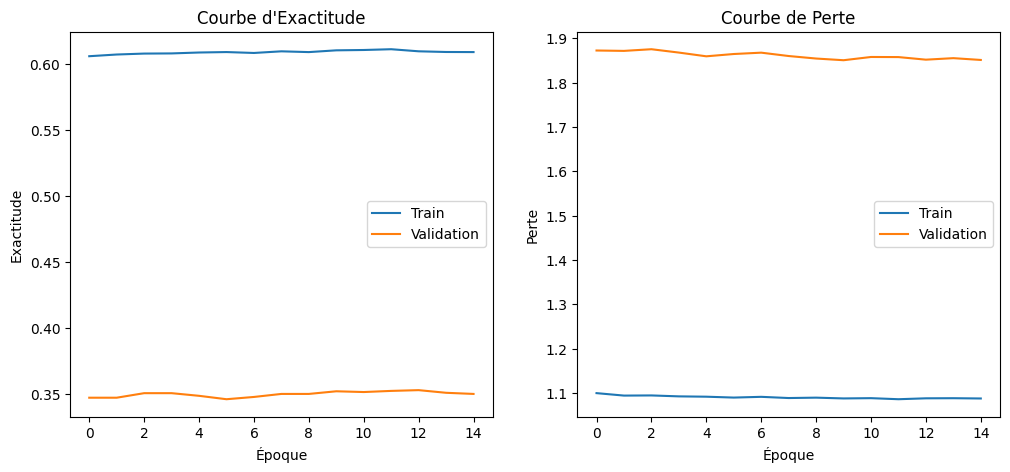

In [30]:
# -----------------------------------------------------------------------------
# 13. Visualisation des courbes d'entraînement (accuracy et loss)
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Courbe d'exactitude
plt.subplot(1, 2, 1)
plt.plot(history_phase2.history['accuracy'], label='Train')
plt.plot(history_phase2.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Exactitude')
plt.legend()
plt.title("Courbe d'Exactitude")

# Courbe de la perte
plt.subplot(1, 2, 2)
plt.plot(history_phase2.history['loss'], label='Train')
plt.plot(history_phase2.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Courbe de Perte")
plt.show()

# Construction of the dataset for training model 05

In [31]:
def afficher_arborescence(dossier, niveau=0, profondeur_max=2):
    """ Affiche l'arborescence des sous-dossiers jusqu'à profondeur_max, sans afficher les fichiers """
    if not os.path.exists(dossier):
        print("Le dossier spécifié n'existe pas.")
        return

    items = sorted(os.listdir(dossier))
    indent = "│   " * niveau

    for i, item in enumerate(items):
        chemin = os.path.join(dossier, item)
        est_dernier = (i == len(items) - 1)
        prefixe = "└── " if est_dernier else "├── "

        # Afficher uniquement les dossiers
        if os.path.isdir(chemin):
            print(indent + prefixe + item)

            # Limite la profondeur d'affichage des sous-dossiers
            if niveau < profondeur_max:
                afficher_arborescence(chemin, niveau + 1, profondeur_max)

# Spécifier le chemin du dossier à afficher
chemin_dossier = "dataset_2/"
afficher_arborescence(chemin_dossier)

├── .ipynb_checkpoints
├── __MACOSX
│   └── affectnet_processed_traitement_v1
│   │   ├── train
│   │   └── val
├── train
│   ├── .ipynb_checkpoints
│   ├── angry
│   ├── disgust
│   ├── fear
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── surprise
└── val
│   ├── .ipynb_checkpoints
│   ├── angry
│   ├── disgust
│   ├── fear
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── surprise


In [32]:
import os
import shutil

def supprimer_dossiers_indesirables(racine, dossiers_a_supprimer=["__MACOSX", ".ipynb_checkpoints"]):
    """
    Parcourt récursivement le dossier racine et supprime les dossiers dont le nom figure dans dossiers_a_supprimer.
    """
    # Parcours de l'arborescence en partant du bas (pour éviter des problèmes lors de la suppression)
    for dossier, sous_dossiers, _ in os.walk(racine, topdown=False):
        for sd in sous_dossiers:
            if sd in dossiers_a_supprimer:
                chemin = os.path.join(dossier, sd)
                try:
                    shutil.rmtree(chemin)
                    print(f"Suppression du dossier : {chemin}")
                except Exception as e:
                    print(f"Erreur lors de la suppression de {chemin} : {e}")

# Exemple d'utilisation
chemin_dossier = "dataset_2/"
supprimer_dossiers_indesirables(chemin_dossier)


Suppression du dossier : dataset_2/val/.ipynb_checkpoints
Suppression du dossier : dataset_2/train/.ipynb_checkpoints
Suppression du dossier : dataset_2/__MACOSX
Suppression du dossier : dataset_2/.ipynb_checkpoints


In [35]:
import shutil

# Chemin du dossier à zipper
dossier = "dataset_2"

# Nom de l'archive (sans l'extension)
nom_archive = "dataset_2_archive"

# Création de l'archive zip
shutil.make_archive(nom_archive, 'zip', dossier)

print(f"Archive {nom_archive}.zip créée avec succès.")


Archive dataset_2_archive.zip créée avec succès.


In [34]:
# --- Téléchargement et décompression du dataset ---
#!rm -rf /content/FER2013
#!kaggle datasets download msambare/fer2013 -p /content/FER2013
!unzip -q /content/FER2013/fer2013.zip -d /content/FER2013


In [37]:
# Spécifier le chemin du dossier à afficher
chemin_dossier = "FER2013/"
afficher_arborescence(chemin_dossier)

├── test
│   ├── angry
│   ├── disgust
│   ├── fear
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── surprise
└── train
│   ├── angry
│   ├── disgust
│   ├── fear
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── surprise


In [38]:
# Spécifier le chemin du dossier à afficher
chemin_dossier = "dataset_2/"
afficher_arborescence(chemin_dossier)

├── train
│   ├── angry
│   ├── disgust
│   ├── fear
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── surprise
└── val
│   ├── angry
│   ├── disgust
│   ├── fear
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── surprise


In [39]:
import os
import shutil

# Définir le nouveau dossier pour fusionner les datasets
nouveau_dataset = "nouveau_dataset"
os.makedirs(nouveau_dataset, exist_ok=True)

# Créer les sous-dossiers train et test dans le nouveau dataset
train_nouveau = os.path.join(nouveau_dataset, "train")
test_nouveau = os.path.join(nouveau_dataset, "test")
os.makedirs(train_nouveau, exist_ok=True)
os.makedirs(test_nouveau, exist_ok=True)

# Liste des catégories
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Créer les dossiers pour chaque catégorie dans train et test
for cat in categories:
    os.makedirs(os.path.join(train_nouveau, cat), exist_ok=True)
    os.makedirs(os.path.join(test_nouveau, cat), exist_ok=True)

def copier_images(src_dossier, dst_dossier):
    """
    Copie les fichiers du dossier source dans le dossier destination.
    En cas de nom de fichier en doublon, un suffixe est ajouté.
    """
    for filename in os.listdir(src_dossier):
        chemin_src = os.path.join(src_dossier, filename)
        if os.path.isfile(chemin_src):
            chemin_dst = os.path.join(dst_dossier, filename)
            # Gérer les doublons en ajoutant un suffixe
            base, ext = os.path.splitext(filename)
            compteur = 1
            while os.path.exists(chemin_dst):
                chemin_dst = os.path.join(dst_dossier, f"{base}_{compteur}{ext}")
                compteur += 1
            shutil.copy(chemin_src, chemin_dst)

# Fusionner le dataset FER2013
fer2013 = "FER2013"

# Copier les images de FER2013/train dans nouveau_dataset/train
for cat in categories:
    dossier_src = os.path.join(fer2013, "train", cat)
    dossier_dst = os.path.join(train_nouveau, cat)
    if os.path.exists(dossier_src):
        copier_images(dossier_src, dossier_dst)

# Copier les images de FER2013/test dans nouveau_dataset/test
for cat in categories:
    dossier_src = os.path.join(fer2013, "test", cat)
    dossier_dst = os.path.join(test_nouveau, cat)
    if os.path.exists(dossier_src):
        copier_images(dossier_src, dossier_dst)

# Fusionner le dataset dataset_2
dataset2 = "dataset_2"

# Copier les images de dataset_2/train dans nouveau_dataset/train
for cat in categories:
    dossier_src = os.path.join(dataset2, "train", cat)
    dossier_dst = os.path.join(train_nouveau, cat)
    if os.path.exists(dossier_src):
        copier_images(dossier_src, dossier_dst)

# Copier les images de dataset_2/val (traité comme test) dans nouveau_dataset/test
for cat in categories:
    dossier_src = os.path.join(dataset2, "val", cat)
    dossier_dst = os.path.join(test_nouveau, cat)
    if os.path.exists(dossier_src):
        copier_images(dossier_src, dossier_dst)

print("Fusion terminée. Le nouveau dataset est disponible dans le dossier:", nouveau_dataset)


Fusion terminée. Le nouveau dataset est disponible dans le dossier: nouveau_dataset


In [40]:
import shutil

# Nom du dossier à zipper et nom de l'archive (sans extension)
dossier = "nouveau_dataset"
nom_archive = "nouveau_dataset_archive"

# Création de l'archive au format zip
shutil.make_archive(nom_archive, 'zip', dossier)

print(f"Archive {nom_archive}.zip créée avec succès.")



Archive nouveau_dataset_archive.zip créée avec succès.
